# Selección de features y modelización

## Importación de librerías

In [164]:
# Librerías para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para manipulación y análisis de datos
import numpy as np
import pandas as pd


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline


from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer, recall_score

from sklearn.model_selection import GridSearchCV


from toolbox_DS import *


import warnings
warnings.filterwarnings(action="ignore", message=r'.*Use subset.*of np.ndarray is not recommended')


## Carga de datos

In [122]:
train_set = pd.read_csv('./data/train_set.csv')
train_set

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Response,income_missing,age,customes_seniority,Household_members,Total_amount,Total_purchase,Median_amount_purchase,Total_cmp,Total_%_cmp
0,9400,1958,2n Cycle,Single,85485.0,0,0,2014-06-21,73,630,...,0,0,57,1,1.0,1383,19,72.789474,0,0.0
1,2804,1975,Master,Single,46098.0,1,1,2012-08-18,86,57,...,1,0,40,3,3.0,120,11,10.909091,0,0.0
2,1503,1976,PhD,Together,162397.0,1,1,2013-06-03,31,85,...,0,0,39,2,4.0,107,1,107.000000,0,0.0
3,5491,1951,Master,Together,47352.0,0,1,2013-04-11,70,172,...,0,0,64,2,3.0,319,16,19.937500,0,0.0
4,2894,1985,Graduation,Single,72903.0,0,0,2013-10-29,74,1067,...,1,0,30,2,1.0,2013,21,95.857143,3,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785,10785,1969,Graduation,Married,44078.0,1,1,2014-06-19,17,24,...,0,0,46,1,4.0,41,7,5.857143,0,0.0
1786,9964,1979,Graduation,Single,61825.0,0,1,2013-08-07,56,162,...,0,0,36,2,2.0,424,15,28.266667,0,0.0
1787,3412,1951,Master,Married,67381.0,0,1,2013-01-15,67,815,...,0,0,64,2,3.0,957,17,56.294118,1,0.2
1788,2811,1963,PhD,Single,48918.0,1,1,2014-04-12,21,52,...,0,0,52,1,3.0,62,7,8.857143,0,0.0


Imputo los cambios que vengo aplicando al dataset.

In [123]:
# Cambio el índice
train_set.set_index('ID', inplace=True)

# Cambio tipo a datetime
train_set['Dt_Customer'] = pd.to_datetime(train_set['Dt_Customer'])

# Cambiar tipo a categóricas
cols_to_category = ['Education', 'Marital_Status']
train_set[cols_to_category] = train_set[cols_to_category].astype('category')

# Elimino columna 'income_missing'
train_set = train_set.drop(columns=['income_missing', 'Year_Birth','Total_%_cmp','Dt_Customer','Median_amount_purchase'])

# Elimino el outlier de Income
train_set = train_set.loc[train_set['Income'] !=666666]

## Transformación de variables

In [124]:
X_train = train_set.drop(columns='Response')
y_train = train_set['Response']

In [125]:
features_num = X_train.select_dtypes(['int','float']).columns
features_cat = X_train.select_dtypes(['object', 'category']).columns
print('features_num', features_num)
print('features_cat', features_cat)

features_num Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'age', 'customes_seniority',
       'Household_members', 'Total_amount', 'Total_purchase', 'Total_cmp'],
      dtype='object')
features_cat Index(['Education', 'Marital_Status'], dtype='object')


In [126]:
# Definimos el OrdinalEncoder con el mapeo de 'education_ode'
ordinal_encoder = OrdinalEncoder(categories=[['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']])

categorical_features_onehot = ['Marital_Status']
categorical_features_ordinal = ['Education']
numerical_features = features_num

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat_onehot', OneHotEncoder(), categorical_features_onehot),
        ('cat_ordinal', Pipeline([
            ('ordinal', ordinal_encoder),
            ('scaler', MinMaxScaler())
        ]), categorical_features_ordinal)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocesor',preprocessor),
    ('algoritmo', RandomForestClassifier())
])

pipeline.fit(X_train,y_train)

X_train_transform = pipeline.named_steps['preprocesor'].transform(X_train)
# X_test_transform = pipeline.named_steps['preprocesor'].transform(X_test)

In [127]:
X_train_transform

array([[8.54850e+04, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 2.50000e-01],
       [4.60980e+04, 1.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 7.50000e-01],
       [1.62397e+05, 1.00000e+00, 1.00000e+00, ..., 1.00000e+00,
        0.00000e+00, 1.00000e+00],
       ...,
       [6.73810e+04, 0.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 7.50000e-01],
       [4.89180e+04, 1.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00],
       [2.32280e+04, 1.00000e+00, 0.00000e+00, ..., 1.00000e+00,
        0.00000e+00, 5.00000e-01]])

In [128]:
features_transformed = pipeline.named_steps['preprocesor'].get_feature_names_out()
features_transformed

array(['num__Income', 'num__Kidhome', 'num__Teenhome', 'num__Recency',
       'num__MntWines', 'num__MntFruits', 'num__MntMeatProducts',
       'num__MntFishProducts', 'num__MntSweetProducts',
       'num__MntGoldProds', 'num__NumDealsPurchases',
       'num__NumWebPurchases', 'num__NumCatalogPurchases',
       'num__NumStorePurchases', 'num__NumWebVisitsMonth',
       'num__AcceptedCmp3', 'num__AcceptedCmp4', 'num__AcceptedCmp5',
       'num__AcceptedCmp1', 'num__AcceptedCmp2', 'num__Complain',
       'num__age', 'num__customes_seniority', 'num__Household_members',
       'num__Total_amount', 'num__Total_purchase', 'num__Total_cmp',
       'cat_onehot__Marital_Status_Alone',
       'cat_onehot__Marital_Status_Divorced',
       'cat_onehot__Marital_Status_Married',
       'cat_onehot__Marital_Status_Others',
       'cat_onehot__Marital_Status_Single',
       'cat_onehot__Marital_Status_Together',
       'cat_onehot__Marital_Status_Widow', 'cat_ordinal__Education'],
      dtype=object)

## Features Selection

### MutualInformation

In [129]:
# Calcular la información mutua
mutual_info = mutual_info_classif(X_train_transform, y_train)

# Ordenar características por importancia
feature_importance = pd.Series(mutual_info, index=features_transformed)
feature_importance.sort_values(ascending=False, inplace=True)

print("Importancia de las características basada en mutual_info_classif:")
print(feature_importance)

Importancia de las características basada en mutual_info_classif:
num__Total_cmp                         0.076297
num__MntMeatProducts                   0.069806
num__Total_amount                      0.057578
num__AcceptedCmp5                      0.045599
num__AcceptedCmp1                      0.040653
num__Income                            0.035239
num__Household_members                 0.034203
num__MntWines                          0.031753
num__MntGoldProds                      0.029291
num__NumCatalogPurchases               0.028841
num__Recency                           0.028177
num__AcceptedCmp3                      0.024367
num__Teenhome                          0.024041
num__AcceptedCmp4                      0.021463
num__NumDealsPurchases                 0.018935
cat_onehot__Marital_Status_Widow       0.018723
num__NumWebPurchases                   0.016273
num__MntFishProducts                   0.015900
num__MntSweetProducts                  0.014075
num__NumStorePurchases

### RFECV

In [130]:
# Entrenar un modelo con todas las características

rfe = RFECV(estimator = XGBClassifier(use_label_encoder=False, n_jobs = -1, eval_metric='auc'),
            cv = 3,
            scoring = 'recall',
            n_jobs = -1)

rfe.fit(X_train_transform,y_train)

RFECV(cv=3,
      estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric='auc',
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=-1,
                              num_parallel_tree=None, random_state=None, ...),
      n_jobs=-1, scoring='recall')

In [131]:
rfe.ranking_

array([ 8,  1,  1,  1, 12,  6,  1,  9,  4,  3,  1,  2,  1,  1,  1,  1,  1,
        1, 15, 17, 20, 11,  1,  1,  7, 13,  1, 19, 14,  1, 18, 10,  5, 16,
        1])

In [132]:
rank_rfe = pd.DataFrame({'variable': feature_importance, 'ranking_rfe': rfe.ranking_}).sort_values(by = 'ranking_rfe')
rank_rfe[:20]

,variable,ranking_rfe
num__MntFishProducts,0.015900,1
num__MntFruits,0.000065,1
num__Total_purchase,0.002621,1
cat_onehot__Marital_Status_Together,0.008137,1
num__age,0.009016,1
num__NumWebPurchases,0.016273,1
cat_onehot__Marital_Status_Widow,0.018723,1
num__NumDealsPurchases,0.018935,1
num__AcceptedCmp4,0.021463,1
num__Teenhome,0.024041,1


In [133]:
def ranking_mi(selector, modo = 'tabla'):
    #Maqueta el ranking
    ranking_mi = pd.DataFrame(selector, index = features_transformed).reset_index()
    ranking_mi.columns = ['variable','importancia_mi']
    ranking_mi = ranking_mi.sort_values(by = 'importancia_mi', ascending = False)
    ranking_mi['ranking_mi'] = np.arange(0,ranking_mi.shape[0])
    #Muestra la salida
    if modo == 'tabla':
        return(ranking_mi)
    else:
        g = ranking_mi[0:15].importancia_mi.sort_values().plot.barh()
        g.set_yticklabels(ranking_mi[0:15].sort_values(by = 'importancia_mi').variable)
        return(g)


In [134]:
rank_mi = ranking_mi(rfe.ranking_)
rank_mi[:20]

,variable,importancia_mi,ranking_mi
20,num__Complain,20,0
27,cat_onehot__Marital_Status_Alone,19,1
30,cat_onehot__Marital_Status_Others,18,2
19,num__AcceptedCmp2,17,3
33,cat_onehot__Marital_Status_Widow,16,4
18,num__AcceptedCmp1,15,5
28,cat_onehot__Marital_Status_Divorced,14,6
25,num__Total_purchase,13,7
4,num__MntWines,12,8
21,num__age,11,9


<Axes: >

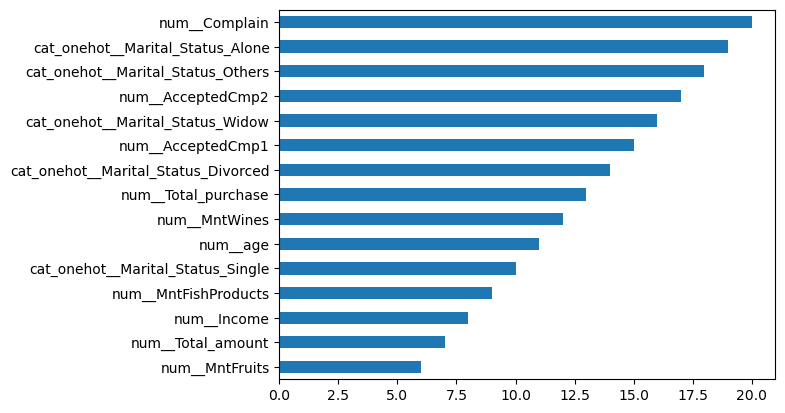

In [135]:
ranking_mi(rfe.ranking_, modo = 'grafico')

### PermutationImportance

In [136]:
xgb = XGBClassifier(use_label_encoder=False, n_jobs = -1, eval_metric='auc')

xgb.fit(X_train_transform,y_train)

permutacion = permutation_importance(xgb, 
                                     X_train_transform, y_train, 
                                     scoring = 'recall',
                                     n_repeats=5, n_jobs = -1)

In [137]:
def ranking_per(predictoras,permutacion):
    ranking_per = pd.DataFrame({'variable': predictoras, 'importancia_per': permutacion.importances_mean}).sort_values(by = 'importancia_per', ascending = False)
    ranking_per['ranking_per'] = np.arange(0,ranking_per.shape[0])
    return(ranking_per)

In [138]:
rank_per = ranking_per(feature_importance,permutacion)
rank_per[:20]

,variable,importancia_per,ranking_per
num__Total_purchase,0.002621,0.308550,0
num__AcceptedCmp5,0.045599,0.248327,1
cat_onehot__Marital_Status_Together,0.008137,0.147955,2
num__age,0.009016,0.081041,3
num__NumDealsPurchases,0.018935,0.068401,4
num__Household_members,0.034203,0.064684,5
num__NumCatalogPurchases,0.028841,0.040149,6
num__Complain,0.000000,0.035688,7
num__Recency,0.028177,0.023792,8
num__MntGoldProds,0.029291,0.020818,9


In [139]:
rank_per.index

Index(['num__Total_purchase', 'num__AcceptedCmp5',
       'cat_onehot__Marital_Status_Together', 'num__age',
       'num__NumDealsPurchases', 'num__Household_members',
       'num__NumCatalogPurchases', 'num__Complain', 'num__Recency',
       'num__MntGoldProds', 'num__AcceptedCmp4', 'num__AcceptedCmp1',
       'num__Total_cmp', 'num__customes_seniority', 'num__MntWines',
       'num__NumWebVisitsMonth', 'num__MntFruits', 'num__AcceptedCmp2',
       'num__Kidhome', 'num__AcceptedCmp3', 'num__MntFishProducts',
       'cat_onehot__Marital_Status_Married', 'num__NumStorePurchases',
       'num__MntSweetProducts', 'cat_onehot__Marital_Status_Single',
       'cat_onehot__Marital_Status_Others', 'cat_onehot__Marital_Status_Alone',
       'num__Income', 'num__Total_amount', 'num__Teenhome',
       'cat_onehot__Marital_Status_Widow',
       'cat_onehot__Marital_Status_Divorced', 'num__MntMeatProducts',
       'num__NumWebPurchases', 'cat_ordinal__Education'],
      dtype='object')

<Axes: >

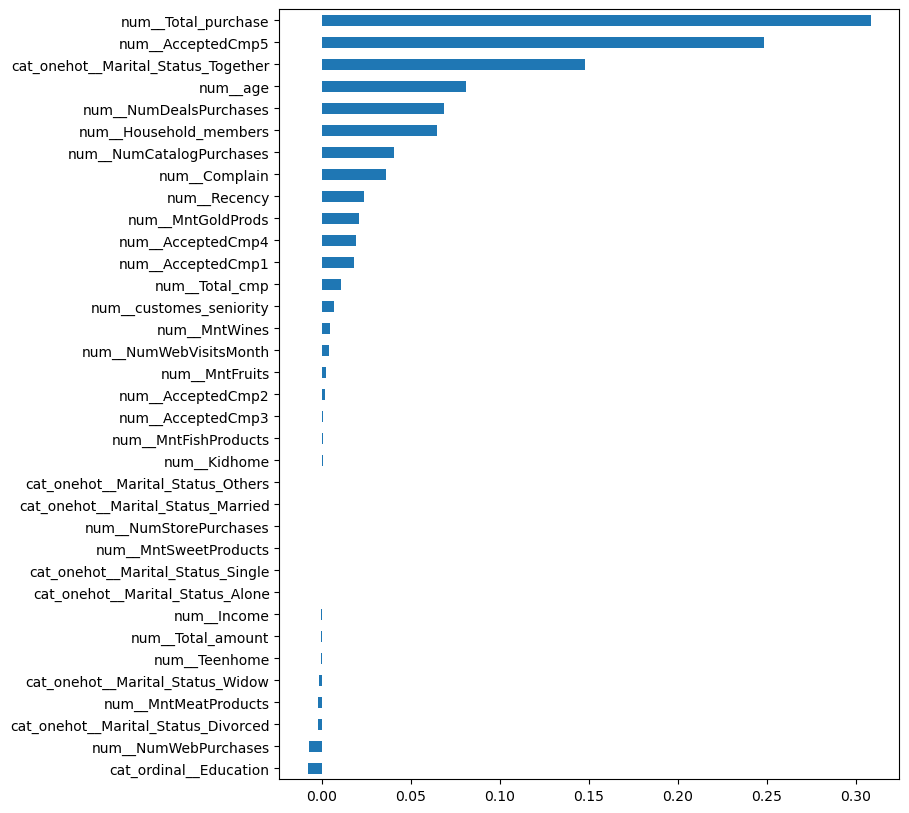

In [140]:
rank_per['importancia_per'].sort_values().plot.barh(figsize=(8, 10))

Cada uno da una cosa diferente.   
Como voy a utiliazar árboles de decisión meteré todas las variables dado que no hay riesgo por dimensionalidad

Pruebo un DecisionTreeClassifier

In [165]:
tree = DecisionTreeClassifier(class_weight='balanced', max_depth=10)

tree.fit(X_train_transform,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10)

In [166]:
tree.feature_importances_

array([3.04660697e-02, 0.00000000e+00, 3.68176933e-03, 9.99235738e-02,
       3.80451763e-02, 3.09741291e-02, 3.79632688e-02, 3.22810388e-02,
       3.41818458e-02, 2.30131676e-02, 6.20148551e-03, 3.57778089e-02,
       8.08200919e-03, 3.79940553e-02, 2.82809948e-02, 0.00000000e+00,
       9.59791331e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.37998939e-16, 3.73562296e-02, 6.90811269e-02, 6.49632804e-02,
       2.33365262e-02, 2.44618506e-02, 2.77942403e-01, 0.00000000e+00,
       3.24533516e-03, 3.48330249e-03, 0.00000000e+00, 8.21868283e-03,
       9.31897492e-03, 0.00000000e+00, 2.21279823e-02])

<Axes: >

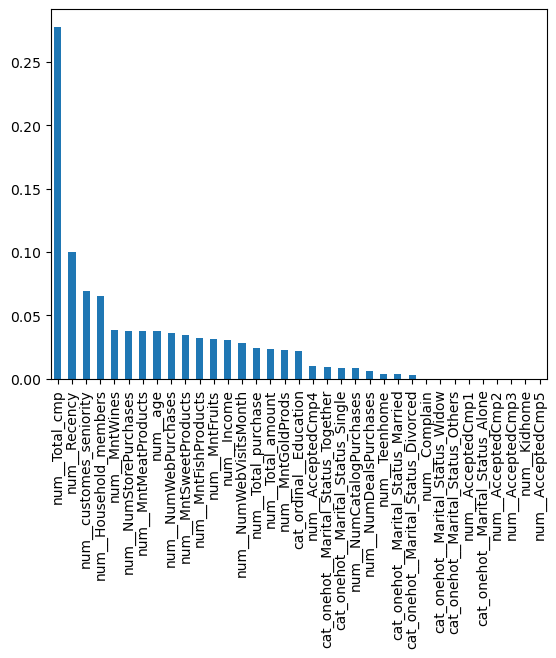

In [170]:
pd.Series(tree.feature_importances_, index = features_transformed).sort_values(ascending=False).plot(kind='bar')

## Modelización

### Prueba de modelos

In [160]:
pipe = Pipeline(steps=[
    ('preprocesor', preprocessor),
    ('algoritmo', RandomForestClassifier())
])

# Supongamos que y es tu vector de etiquetas
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

# Definir el grid de hiperparámetros
grid = [
    {'algoritmo': [RandomForestClassifier()],
     'algoritmo__max_depth': [9, 10, 11],
     'algoritmo__n_estimators': [50, 100, 200],
     'algoritmo__class_weight':['balanced']},
   
    {'algoritmo': [XGBClassifier()],
     'algoritmo__learning_rate': [0.1, 0.3, 0.5],
     'algoritmo__n_estimators': [100, 500, 1000],
     'algoritmo__scale_pos_weight':[scale_pos_weight]},
    
    {'algoritmo': [LGBMClassifier()],
     'algoritmo__learnin_rate': [0.1, 0.3, 0.5],
     'algoritmo__n_estimators': [100, 500, 1000],
     'algoritmo__scale_pos_weight':[scale_pos_weight]}
]


# Crear un scorer personalizado para el recall de la clase positiva
recall_scorer = make_scorer(recall_score, pos_label=1)

# Realizar GridSearchCV con el scorer personalizado
grid_search = GridSearchCV(pipe, 
                           grid, 
                           cv=5, 
                           scoring=recall_scorer, 
                           n_jobs=-1)


grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y parámetros
best_model = grid_search.best_estimator_
print("Mejor modelo y parámetros:", grid_search.best_params_)

Mejor modelo y parámetros: {'algoritmo': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), 'algoritmo__learning_rate': 0.1, 'algoritmo__n_estimators': 100, 'algoritmo__scale_pos_weight': 5.650557620817844}


In [161]:
grid_search.best_score_

0.5909154437456324

In [162]:
grid_search.cv_results_

{'mean_fit_time': array([ 0.76913781,  1.8352035 ,  3.40931664,  0.83547654,  1.61227136,
         3.12604747,  0.9585988 ,  1.72259884,  5.2256999 ,  1.92730899,
         6.34122367,  9.08063536,  1.6447628 ,  3.08278952,  5.1408947 ,
         0.861695  ,  2.49310436,  4.75781264,  5.21898723, 12.35940967,
        18.92611732,  4.32029018, 12.06857305, 19.0117218 ,  3.52267566,
        13.57917275, 14.63530765]),
 'std_fit_time': array([0.05481764, 0.11038535, 0.15047487, 0.05386745, 0.1285286 ,
        0.20666326, 0.11755927, 0.17778206, 0.95951917, 0.41877028,
        0.43902409, 0.72670994, 0.31123418, 0.11033226, 0.13157503,
        0.1289819 , 0.12573033, 0.30629603, 1.25968172, 0.57175025,
        0.70322552, 0.27818945, 0.66869007, 1.45981159, 0.37505233,
        1.07288105, 0.71014961]),
 'mean_score_time': array([0.06928301, 0.13058925, 0.18438845, 0.08252463, 0.09385166,
        0.28312645, 0.11740565, 0.09352045, 0.28455391, 0.07841167,
        0.14532347, 0.09405022, 0.079

In [163]:
df_cv_results = pd.DataFrame(grid_search.cv_results_)
df_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algoritmo,param_algoritmo__class_weight,param_algoritmo__max_depth,param_algoritmo__n_estimators,param_algoritmo__learning_rate,param_algoritmo__scale_pos_weight,param_algoritmo__learnin_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.769138,0.054818,0.069283,0.011117,RandomForestClassifier(),balanced,9,50,NaN,NaN,NaN,"{'algoritmo': RandomForestClassifier(), 'algor...",0.481481,0.407407,0.462963,0.407407,0.433962,0.438644,0.029664,21
1,1.835204,0.110385,0.130589,0.025913,RandomForestClassifier(),balanced,9,100,NaN,NaN,NaN,"{'algoritmo': RandomForestClassifier(), 'algor...",0.500000,0.407407,0.388889,0.444444,0.528302,0.453809,0.053176,19
2,3.409317,0.150475,0.184388,0.055913,RandomForestClassifier(),balanced,9,200,NaN,NaN,NaN,"{'algoritmo': RandomForestClassifier(), 'algor...",0.500000,0.444444,0.370370,0.425926,0.509434,0.450035,0.050958,20
3,0.835477,0.053867,0.082525,0.029393,RandomForestClassifier(),balanced,10,50,NaN,NaN,NaN,"{'algoritmo': RandomForestClassifier(), 'algor...",0.462963,0.407407,0.351852,0.407407,0.377358,0.401398,0.037135,23
4,1.612271,0.128529,0.093852,0.006771,RandomForestClassifier(),balanced,10,100,NaN,NaN,NaN,"{'algoritmo': RandomForestClassifier(), 'algor...",0.407407,0.370370,0.370370,0.425926,0.415094,0.397834,0.023183,24
5,3.126047,0.206663,0.283126,0.080028,RandomForestClassifier(),balanced,10,200,NaN,NaN,NaN,"{'algoritmo': RandomForestClassifier(), 'algor...",0.444444,0.407407,0.351852,0.407407,0.415094,0.405241,0.029979,22
6,0.958599,0.117559,0.117406,0.047610,RandomForestClassifier(),balanced,11,50,NaN,NaN,NaN,"{'algoritmo': RandomForestClassifier(), 'algor...",0.444444,0.333333,0.333333,0.407407,0.339623,0.371628,0.045912,27
7,1.722599,0.177782,0.093520,0.011496,RandomForestClassifier(),balanced,11,100,NaN,NaN,NaN,"{'algoritmo': RandomForestClassifier(), 'algor...",0.370370,0.462963,0.351852,0.351852,0.396226,0.386653,0.041478,26
8,5.225700,0.959519,0.284554,0.042365,RandomForestClassifier(),balanced,11,200,NaN,NaN,NaN,"{'algoritmo': RandomForestClassifier(), 'algor...",0.444444,0.351852,0.351852,0.370370,0.433962,0.390496,0.040476,25
9,1.927309,0.418770,0.078412,0.013593,"XGBClassifier(base_score=None, booster=None, c...",NaN,NaN,100,0.1,5.650558,NaN,"{'algoritmo': XGBClassifier(base_score=None, b...",0.574074,0.648148,0.555556,0.629630,0.547170,0.590915,0.040551,1
